# Постановка задачи

Имеются изображения технологического процесса разлива металлических циллиндров. Есть риск нарушения технологии, когда стенки цилиндра не успевают застывать и трескаются. Не застывшый металл выливается, не образуя требуюмую заготовку. Необходимо оперативно определить лунку где произошел пролив. При этом пролив дольно редкое явление. Гораздо больше изображений можно собрать без пролива в лунке.

## Задача: построить модель (на основе автоэнкодера) определяющую состояние лунки пролив\не пролив.

title

Датесет
Данные - вырезанные изображения лунок. Ссыла на даасет

dataset
```
├── proliv  # изображения с проливами
|       ├── 000.jpg
│       ├── 001.jpg
│       │   └── ...
|
├── test  # тестовая выборка где перемешаны проливы и не_проливы
│       ├── imgs
│       │   ├── 000.jpg
│       │   ├── 001.jpg
│       │   └── ...
│       └── test_annotation.txt
|
├── train  #  обучающая выборка из не_проливов
|       ├── 000.jpg
│       ├── 001.jpg
│       └── ...
```
## План решения
- Имплементировать или найти автоэкодер (можно для старта взять пример из лекции по автоэнкодерам)
- Обучаем автоэнкодер на не_проливах (dataset\train)
- Если через такой автоэнкодер прогнать изображение пролива, то MSE между входным изображением и выходным будет больше, чем если прогнать изображение без пролива. Следовательно, если определить некторое пороговое значение MSE, можно классифицировать изображение на классы пролив\не_пролив. Если MSE между входной картинкой и выходной больше фиксированного порога, то на изображении пролив.
- В качестве loss функции используем MSE (как минимум для baseline)
- Для определения порога используем изображения из dataset\proliv
- Пишем метод классификации лунок
- На изображениях из dataset\test тестируем качество. Считаем True_positive_rate и True_negative_rate.
- Цель: получить на тесте максимизаровать метрики True_positive_rate и True_negative_rate (получить более 91% по каждой)


# Imports

In [ ]:
!pip install lightning

In [426]:
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, Callback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
from PIL import Image
import glob

RANDOM_STATE = 42
np.seed = 42
torch.seed = 42

# Data

In [427]:
batch_size = 256
num_workers = 4

SHAPE = (64, 64)

DATA_PATH = '/kaggle/input/metal-spill-detection/dataset'

In [428]:
train_path = os.path.join(DATA_PATH + '/train/')
paths = glob.glob(train_path + '*')

In [429]:
import torchvision.transforms.functional as TF

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [430]:
# попробуем 0-1 нормализацию
train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
    AddGaussianNoise(0, 0.01),
])

val_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

In [431]:
class AnomalyDataset(Dataset):
    def __init__(self, paths: list[str], transforms: transforms.Compose):
        self.paths = paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert('L')
        tensor = self.transforms(img)
        return tensor
        

In [432]:
test_fnames = []
gt_labels = []
with open(os.path.join(DATA_PATH + '/test/test_annotation.txt'), 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(os.path.join(DATA_PATH + '/test/imgs/' + fname))
        gt_labels.append(int(label))

In [433]:
class TestAnomalyDataset(Dataset):
    def __init__(self, paths: list[str], labels: list[int], transforms: transforms.Compose):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert('L')
        label = self.labels[i]
        tensor = self.transforms(img)
        return tensor, label

In [434]:
train_paths, val_paths = train_test_split(paths, test_size=0.1, random_state=RANDOM_STATE)

In [435]:
train_set = AnomalyDataset(train_paths, train_transforms)
val_set = AnomalyDataset(val_paths, val_transforms)
test_set = TestAnomalyDataset(test_fnames, gt_labels, val_transforms)

In [436]:
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [437]:
train_path = os.path.join(DATA_PATH + '/train/')
paths = glob.glob(train_path + '*')

In [438]:
proliv_dataset = AnomalyDataset(glob.glob(os.path.join(DATA_PATH + '/proliv/') + '*.jpg'), val_transforms)
proliv_loader = DataLoader(proliv_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [439]:
for images in train_loader:
    break

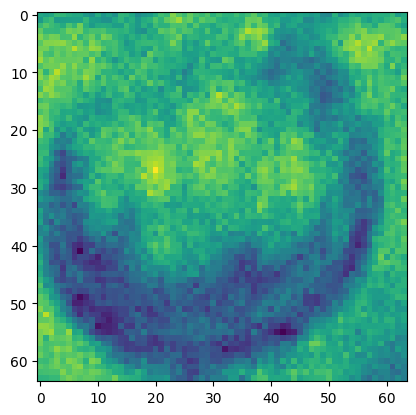

In [440]:
plt.imshow(images[0][0])

In [441]:
for images in proliv_loader:
    break

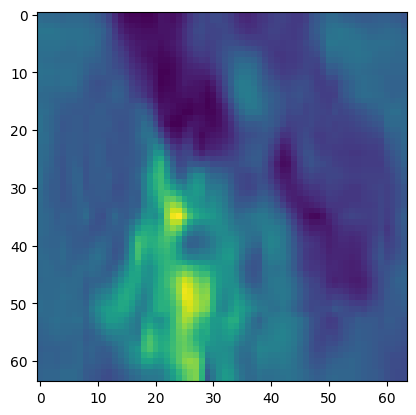

In [442]:
plt.imshow(images[0][0])

In [443]:
for images, labels in test_loader:
    break

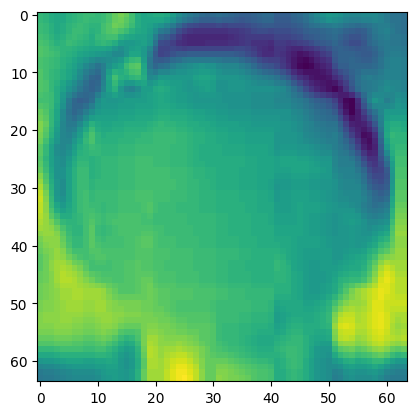

In [444]:
plt.imshow(images[labels==1][0][0])

# Model

### Unet Encoder

In [445]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [446]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [471]:
class UNetEncoder(nn.Module):
    def __init__(self, n_classes):
        super(UNetEncoder, self).__init__()

        self.conv_down1 = ConvBlock(1, 16)
        self.conv_down2 = Down(16, 24)
        self.conv_down3 = Down(24, 32)

    def forward(self, x):
        x = self.conv_down1(x)
        x = self.conv_down2(x)
        x = self.conv_down3(x)  # Включаем дополнительный слой в прямой проход
        return x

In [472]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [473]:
encoder = UNetEncoder(n_classes = 1)
decoder = Decoder()
z = encoder(images)
print(z.shape)
out = decoder(z)
print(out.shape)
assert out.shape == images.shape

torch.Size([256, 32, 16, 16])
torch.Size([256, 1, 64, 64])


In [474]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training loop

In [475]:
class CalculateThresholdCallback(Callback):
    def __init__(self, every_n_epochs, val_loader, proliv_loader):
        self.every_n_epochs = every_n_epochs
        self.val_loader = val_loader
        self.proliv_loader = proliv_loader
        
    def on_train_epoch_end(self, trainer, pl_module):
        if not trainer.current_epoch % self.every_n_epochs == 0:
            return

        mse_normal = self.calculate_mse_for_loader(pl_module.model, self.val_loader, pl_module.device)
        mse_anomaly = self.calculate_mse_for_loader(pl_module.model, self.proliv_loader, pl_module.device)

        labels = np.array([0] * len(mse_normal) + [1] * len(mse_anomaly))
        mse_values = np.concatenate([mse_normal, mse_anomaly])
        fpr, tpr, thresholds = roc_curve(labels, mse_values)
        roc_auc = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        pl_module.log('roc_auc', roc_auc)
        pl_module.log('opt_thresh', optimal_threshold)
        pl_module.optimal_threshold = optimal_threshold

    @staticmethod
    def calculate_mse_for_loader(model, loader, device):
        mse_values = []
        model.eval()
        with torch.no_grad():
            for images in loader:
                images = images.to(device)
                outputs = model(images)
                mse = F.huber_loss(outputs, images, reduction='none').mean([1, 2, 3])
                mse_values.extend(mse.detach().cpu().numpy())
        model.train()
        return np.array(mse_values)

In [476]:
class TestAnomalyCallback(Callback):
    def __init__(self, every_n_epochs, test_loader):
        self.every_n_epochs = every_n_epochs
        self.test_loader = test_loader

    def on_train_epoch_end(self, trainer, pl_module):
        if not trainer.current_epoch % self.every_n_epochs == 0:
            return

        

        all_labels = []
        all_preds = []
        pl_module.model.eval()
        for images, labels in self.test_loader:
            with torch.no_grad():
                images = images.to(pl_module.device)
            outputs = pl_module(images)
            mse = F.huber_loss(outputs, images, reduction='none').mean([1, 2, 3])
            preds = mse > pl_module.optimal_threshold

            all_labels.extend(labels.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())

        pl_module.model.train()
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        pl_module.log('metrics/tpr', tpr)
        pl_module.log('metrics/tnr', tnr)
        pl_module.log('metrics/mean', (tpr+tnr)/2)

In [477]:
class LModule(L.LightningModule):
    def __init__(self, model: nn.Module):
        super(LModule, self).__init__()
        self.model = model
        self.loss = nn.HuberLoss() 
        self.optimal_threshold = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, images, batch_idx):
        outputs = self.model(images)
        loss = self.loss(outputs, images)
        self.log('loss/train', loss)
        return loss

    def validation_step(self, images, batch_idx):
        outputs = self.model(images)
        loss = self.loss(outputs, images)
        
        self.log('loss/val', loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-5)

In [478]:
every_n_epochs = 5

In [479]:
eval_callback = CalculateThresholdCallback(every_n_epochs=every_n_epochs, val_loader=val_loader, proliv_loader=proliv_loader)
test_callback = TestAnomalyCallback(every_n_epochs=every_n_epochs, test_loader=test_loader)

In [480]:
callbacks = [eval_callback, test_callback]

In [481]:
max_epochs = 10
log_every_n_steps = 10

In [482]:
model = Autoencoder(GatedEncoder(), Decoder())

In [483]:
module = LModule(model)
trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=max_epochs,
    log_every_n_steps=log_every_n_steps,
    logger=TensorBoardLogger('../logs_hw2', f'gated_huber_loss'),
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [484]:
%%time
trainer.fit(module, train_loader, val_dataloaders=val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 11.9 K
1 | loss  | HuberLoss   | 0     
--------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 5.65 s, sys: 5 s, total: 10.6 s
Wall time: 1min 2s


In [486]:
model.to('cpu')
model.eval()
print()

In [487]:
mse_normal = []
for images in val_loader:
    with torch.inference_mode():
        out = model(images)
        mse = F.huber_loss(out, images, reduction='none').mean([1, 2, 3])
    mse_normal.extend(mse.detach().cpu().numpy())
mse_normal = np.array(mse_normal)

In [488]:
%%time
mse_anomaly = []
for images in proliv_loader:
    with torch.inference_mode():
        out = model(images)
        mse = F.huber_loss(out, images, reduction='none').mean([1, 2, 3])
    mse_anomaly.extend(mse.detach().cpu().numpy())
mse_anomaly = np.array(mse_anomaly)

CPU times: user 181 ms, sys: 256 ms, total: 437 ms
Wall time: 480 ms


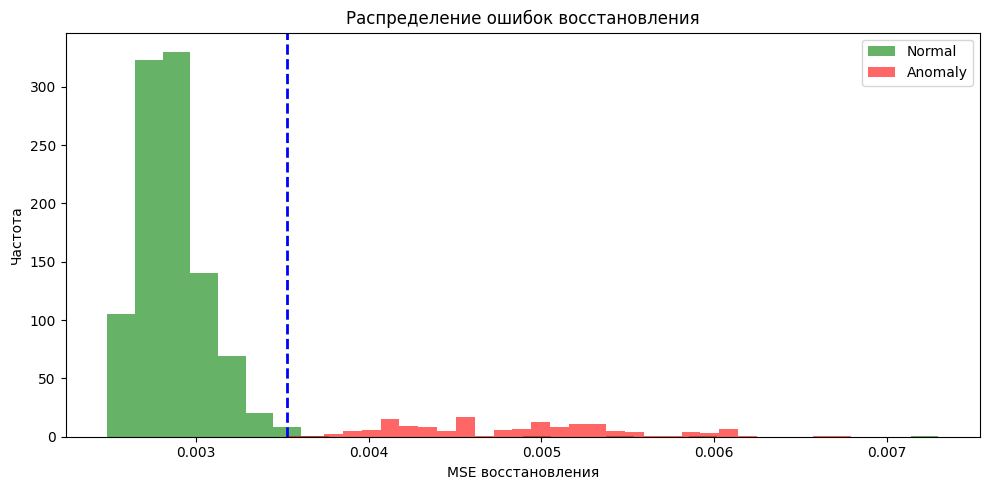

In [505]:
labels = np.array([0] * len(mse_normal) + [1] * len(mse_anomaly))
mse_values = np.concatenate([mse_normal, mse_anomaly])
fpr, tpr, thresholds = roc_curve(labels, mse_values)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(10, 5))

plt.hist(mse_normal, bins=30, alpha=0.6, color='g', label='Normal')
plt.hist(mse_anomaly, bins=30, alpha=0.6, color='r', label='Anomaly')
plt.axvline(optimal_threshold, color='b', linestyle='dashed', linewidth=2)
plt.title('Распределение ошибок восстановления')
plt.xlabel('MSE восстановления')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

In [129]:
optimal_threshold

0.0023036131

In [491]:
test_annotation = open(os.path.join(DATA_PATH + '/test/test_annotation.txt')).readlines()

In [492]:
os.path.join(DATA_PATH + '/test/test_annotation.txt')

'/kaggle/input/metal-spill-detection/dataset/test/test_annotation.txt'

In [493]:
test_root = os.path.join(DATA_PATH + '/test/imgs')
test_root

'/kaggle/input/metal-spill-detection/dataset/test/imgs'

In [494]:
test_fnames = []
gt_labels = []
with open(os.path.join(DATA_PATH + '/test/test_annotation.txt'), 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(fname)
        gt_labels.append(int(label))

In [495]:
gt_labels = np.array(gt_labels)

In [496]:
pred_errors = []
for fname in test_fnames:
    img = Image.open(f"{test_root}/{fname}").convert('L')
    tensor = val_transforms(img)
    with torch.inference_mode():
        out = model(tensor.unsqueeze(0))
        mse = F.huber_loss(out.squeeze(0), tensor)
        pred_errors.append(mse.item())

In [497]:
pred_errors = np.array(pred_errors)

In [516]:
pred_labels = pred_errors > 0.0035

In [518]:
tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()

# Расчет TPR и TNR
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

True Positive Rate (TPR): 0.9537
True Negative Rate (TNR): 0.9271


In [ ]:
thresholds = np.linspace(optimal_threshold * 0.5, optimal_threshold * 1.5, 200)

tpr_list = []
tnr_list = []

for threshold in thresholds:
    pred_labels = pred_errors > threshold
    tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    tpr_list.append(tpr)
    tnr_list.append(tnr)

plt.figure(figsize=(8, 6))
plt.plot(tpr_list, tnr_list, marker='o')
plt.xlabel('True Positive Rate (TPR)')
plt.ylabel('True Negative Rate (TNR)')
plt.grid(True)
plt.show()